# Classification on College Score Board Data

## Data Preparation

In [107]:
import pickle
from sklearn.linear_model    import SGDClassifier,LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

   ### Import the data

In [4]:
college = pickle.load(open("college.p","rb"))
college_label = pickle.load(open("college_label.p","rb"))
college_test = pickle.load(open("college_test.p","rb"))
college_test_label = pickle.load(open("college_test_label.p","rb"))

### Encode earnings into categorical variable

In [6]:
quantiles = college_label.quantile(q=0.5)

In [7]:
quantiles #median earnings

30600.0

In [8]:
def median_code(data):
    if data < quantiles:
        return 0
    else:
        return 1

In [9]:
college_label = college_label.map(median_code)

In [55]:
college_test_label = college_test_label.map(median_code)

## Logistic Classifier

### Train a logistic regression model

In [2]:
log_clf = LogisticRegression(solver = 'liblinear',
                            random_state = 42)

In [10]:
train_fit = log_clf.fit(college,college_label)

In [11]:
train_predict = train_fit.predict(college)

### Performance Measures

In [12]:
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(college,college_label):
    clone_clf = clone(log_clf)
    X_train_folds = college[train_index]
    y_train_folds = (np.array(college_label)[train_index])
    X_test_fold = college[test_index]
    y_test_fold = np.array(college_label)[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.782907049283
0.842072409488
0.73720349563


In [72]:
np.array(college_label)

array([0, 1, 1, ..., 1, 1, 1])

In [21]:
y_train_folds

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [22]:
confusion_matrix(college_label,train_predict)

array([[2120,  283],
       [ 460, 1944]])

In [102]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

## Random Forest Classifier

### Train a random forest model

In [25]:
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(college, college_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

### Performance Measures

#### Measuring accuracy on training set

In [83]:
pred = rf_clf.predict(college)
rf_clf.score(college, college_label)

0.99251092157270648

In [61]:
print(confusion_matrix(college_label,pred))

[[2396    7]
 [  29 2375]]


In [85]:
print(classification_report(college_label, pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2403
          1       1.00      0.99      0.99      2404

avg / total       0.99      0.99      0.99      4807



    Note: classification-report() function return all necessary metrics at the same time. precision_score() function and recall_score() function return value for positive class only.

The random forest model performs very well on the trainning data set, with 99% accuracy. As the data set is not skewed, the precision and recall are also very satisfied. When it predicts the earning will larger than \$30.6K, it is correct almost 100% of the time. Moreover, it detects 99% of universities that have earnings larger than \$30.6K.

#### Measuring accuracy using cross-validation

In [68]:
# 3 fold cross-validation
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(college,college_label):
    clone_clf = clone(rf_clf)
    X_train_folds = college[train_index]
    y_train_folds = (np.array(college_label)[train_index])
    X_test_fold = college[test_index]
    y_test_fold = np.array(college_label)[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.799750467873
0.84581772784
0.82709113608


We can see that model accuracy decreases on the subsets. When we categorize the earning varibale, we use the median earning of the whole train data set. This could be the reason why accuracy reduces a lot through cross-validation.

#### Confusion Matrix

Instead of making predictions on the test set directly, we use the cross_cal_predict() function to get a clean prediction for each instance in the training set. As each prediction is made by a model that never saw the data during training.

In [91]:
pred = cross_val_predict(rf_clf, college, college_label, cv=3)
print(confusion_matrix(college_label, pred))

[[2094  309]
 [ 536 1868]]


#### Precision and recall

In [77]:
print(classification_report(college_label, pred)) 

             precision    recall  f1-score   support

          0       0.80      0.87      0.83      2403
          1       0.86      0.78      0.82      2404

avg / total       0.83      0.82      0.82      4807



We can see that all classifier matrics get worse now. Total accuracy reduces from 99% to 83%. When the random forest model predicts that the university's earning will larger than \$30.6K, it is correct only 86% of the time. Moreover, it detects only 78% of universities that have earnings larger than \$30.6K.

### The ROC curve

In [98]:
pred_proba = cross_val_predict (rf_clf, college, college_label, cv=3, method='predict_proba') [:,1]

In [100]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(college_label, pred_proba) 

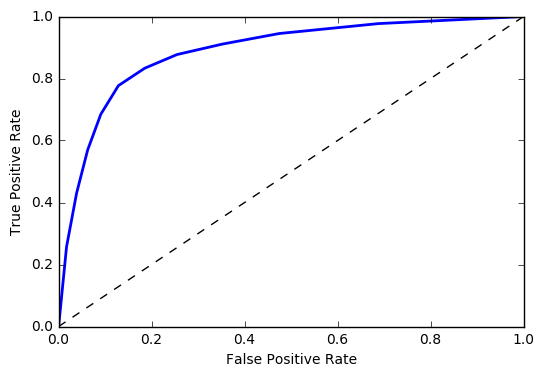

In [105]:
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
plt.show()

In [108]:
roc_auc_score(college_label, pred_proba)

0.88625750673554893